# Train DeBCR tutorial

In [1]:
import tensorflow as tf
import os 
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import random
from util.utils import *
from configs.yaml_loader import *
import argparse

2024-07-02 20:57:22.031359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 20:57:22.192747: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 20:57:23.005822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ayushke/miniconda3/envs/debcr-env/lib/python3.9/site-packages/nvidia/cudnn/lib:/u

## Config

In [2]:
# define config (yaml) path

config_path = 'configs/EM_low_freq_denoising.yaml'
#config_path = 'configs/LM_2D_denoising.yaml'

config = get_config(config_path)

In [3]:
# set GPU ID to use
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Data

In [4]:
# define the data path 
from natsort import natsorted

DATA_PATH = config.data['data_dir']  # use the absolute path!

# training
train_data_dir = DATA_PATH + 'train/'
train_data_list = natsorted(os.listdir(train_data_dir))

# validate
val_data_dir = DATA_PATH + 'val/'
val_data_list = natsorted(os.listdir(val_data_dir))  

In [5]:
# call for the data generator

# tranining
train_gen_class = DataGenerator(train_data_dir, train_data_list,config.data['train_batch'], config.data['noise'], config.data['domain'])
train_img_datagen = train_gen_class.imageLoader()

# validate
val_gen_class = DataGenerator(val_data_dir, val_data_list, config.data['val_batch'], config.data['noise'], config.data['domain'])
val_img_datagen = val_gen_class.imageLoader()

Loading dataset: train.npz
(32, 128, 128, 1)


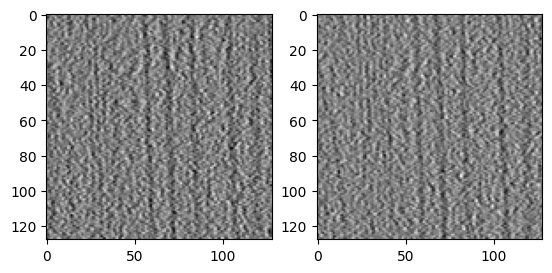

21


In [6]:
# sanity check

w_img_temp, o_temp = train_img_datagen.__next__()
print(w_img_temp.shape)

slice_num = random.randint(0, w_img_temp.shape[0]-1)
subShow(w_img_temp[slice_num].squeeze(), o_temp[slice_num].squeeze(), config.data['domain'])
print(slice_num)

Loading dataset: val_new.npz
(16, 128, 128, 1)


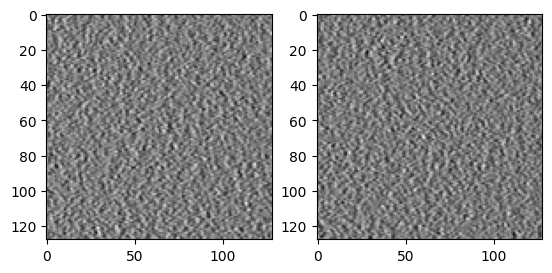

1


In [7]:
# sanity check

w_img_temp, o_temp = val_img_datagen.__next__()
print(w_img_temp.shape)

slice_num = random.randint(0, w_img_temp.shape[0]-1)
subShow(w_img_temp[slice_num].squeeze(), o_temp[slice_num].squeeze(), config.data['domain'])
print(slice_num)

# Model

In [8]:
from models.DeBCR import *
from util.loss_func import *
from util.metrics import *

model = model_DeBCR()
model.compile(optimizer=config.training['opti'], loss=loss_function_mimo, metrics=[metrics_func_mimo])
print(model.input_shape, model.output_shape) # [(None, 128, 128, 1), (None, 64, 64, 1), (None, 32, 32, 1)] 
print(model.summary())

2024-07-02 20:57:32.724165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 20:57:34.928367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33932 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:12:00.0, compute capability: 8.6


[(None, 128, 128, 1), (None, 64, 64, 1), (None, 32, 32, 1)] [(None, 128, 128, 1), (None, 64, 64, 1), (None, 32, 32, 1)]
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x0_input (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 x2_input (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 x4_input (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                       

# Train

In [9]:
# choose the trainer

if config.data['domain'] == 'LM':
    from trainer_DeBCR import train_model_LM as trainer
elif config.data['domain'] == 'EM':
    from trainer_DeBCR import train_model_EM as trainer
else:
    print('illegal trainer')

2024-07-02 20:57:41.674636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-02 20:57:41.747346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8906
2024-07-02 20:57:45.439385: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x87c30110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-02 20:57:45.439426: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-07-02 20:57:45.444963: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 20:57:45.633969: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0 tf.Tensor(2.7600918, shape=(), dtype=float32) tf.Tensor(5.816398, shape=(), dtype=float32)


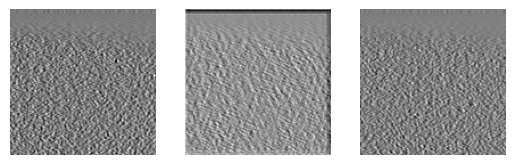

50 tf.Tensor(1.3344865, shape=(), dtype=float32) tf.Tensor(17.56057, shape=(), dtype=float32)
100 tf.Tensor(1.3632374, shape=(), dtype=float32) tf.Tensor(17.374735, shape=(), dtype=float32)


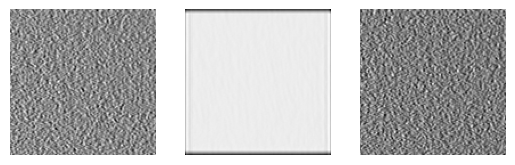

150 tf.Tensor(1.2954832, shape=(), dtype=float32) tf.Tensor(17.932205, shape=(), dtype=float32)
200 tf.Tensor(1.3070575, shape=(), dtype=float32) tf.Tensor(17.91771, shape=(), dtype=float32)


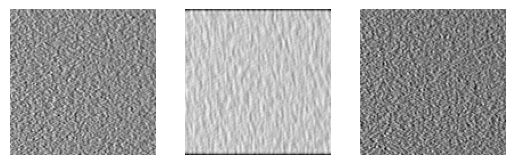

250 tf.Tensor(1.3103333, shape=(), dtype=float32) tf.Tensor(17.946508, shape=(), dtype=float32)
300 tf.Tensor(1.3027623, shape=(), dtype=float32) tf.Tensor(17.628864, shape=(), dtype=float32)


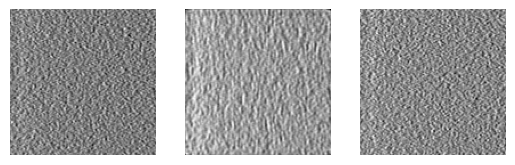

350 tf.Tensor(1.2914727, shape=(), dtype=float32) tf.Tensor(18.075546, shape=(), dtype=float32)
400 tf.Tensor(1.3309438, shape=(), dtype=float32) tf.Tensor(17.935955, shape=(), dtype=float32)


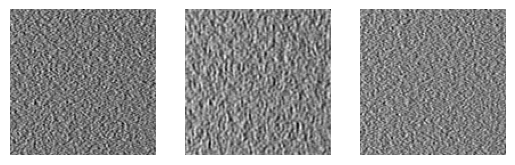

450 tf.Tensor(1.3238912, shape=(), dtype=float32) tf.Tensor(17.746971, shape=(), dtype=float32)
Elapsed time: 301.49116373062134


In [10]:
# training

model_trained = trainer(config, model, multi_input, loss_function_mimo, metrics_func_mimo, train_img_datagen, val_img_datagen, config.training['visual'])

# Visualization

In [11]:
# visualize part prediction results

w_img_val_temp, o_val_temp = val_img_datagen.__next__()
w_val_temp_list, o_val_temp_list = multi_input(w_img_val_temp, o_val_temp)

pred_val_list = model_trained.predict(w_val_temp_list) 

1/1 [==============================] - 4s 4s/step


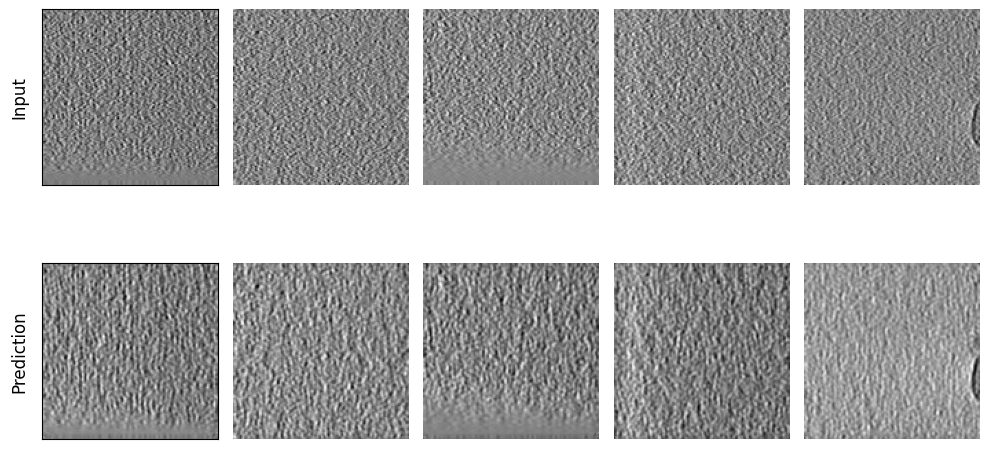

In [12]:
# choose the visualizer

if config.data['domain'] == 'LM':
    show_grid_LM(pred_val_list[0], w_val_temp_list[0], o_val_temp_list[0])
elif config.data['domain'] == 'EM':
    show_grid_EM(pred_val_list[0], w_val_temp_list[0])
else:
    print('illegal visualizer')